## Gimodules usage examples

This jupyter notebook is intended to demonstrate the workflow or usage of the gimodules package.
The purpose of this package is to provide a python interface to the GI Cloud API.
These include:
- Login to the cloud
- Get specific variables with specific dates
- Get measurements
- Get data as dataframe
- UDBF files
- Upload CSV
- Get all stream metadata


These environments and examples are tested with Python 3.10.


In [1]:
# Enable autoreload for debugging
#%load_ext autoreload
#%autoreload 2

In [82]:
#%pip install gimodules==0.1.0
# Import the CloudRequest class
from gimodules.cloudconnect.cloud_request import CloudRequest, DataFormat
gi = CloudRequest()

# You can login with username and password or with an access token or using a .env file
#gi.login(url='https://demo.gi-cloud.io', user='', password='')
#gi.login(url='https://demo.gi-cloud.io', access_token='')
gi.login(use_env_file=True)


INFO:root:0cea000d-4919-42f0-9d4d-59368a96f3ee
INFO:root:Streamname:         OTF4_CMS_Skimmer
Streamid:           2d5cfdc8-0ef4-11ec-b094-02420a0001be
first ts:           1630920600000 2021-09-06 09:30:00
last ts:            1727078460000 2024-09-23 08:01:00
Samplerate:         10

INFO:root:Streamname:         PV_Inv-A.02.02
Streamid:           6d300808-d85e-3128-b7bf-0a7b01069860
first ts:           1609455900000 2020-12-31 23:05:00
last ts:            1672528500000 2022-12-31 23:15:00
Samplerate:         1

INFO:root:Streamname:         OTF4_CMS_Live_New
Streamid:           708d5f80-509b-11e9-8bd7-02420a000a33
first ts:           1714771740000 2024-05-03 21:29:00
last ts:            1732551240000 2024-11-25 16:14:00
Samplerate:         10

INFO:root:Streamname:         PV_Inv-A.01.01
Streamid:           9e779707-0a04-3f86-9a0b-8b378a580517
first ts:           1609455900000 2020-12-31 23:05:00
last ts:            1672528500000 2022-12-31 23:15:00
Samplerate:         1

INFO:root:Stre

### Get specific variables with specific dates

We take the ID of a stream and select all variables. Then we filter the variables by a specific subname.
Now, we fetch data for individual days concurrently.
Keep in mind that for each result DF, we drop the first three columns that contain metadata.
Finally, we concatenate and sort by the date column.

In [8]:
gi._get_stream_name_for_sid('d00bf736-3af4-459d-9567-39e4bfb17409')

'demo_otf4'

In [3]:
from gimodules.cloudconnect.cloud_request import GIStreamVariable
from concurrent.futures import ThreadPoolExecutor
from typing import List
import pandas as pd

# Only get pattern matching variables
variables = gi.get_all_vars_of_stream('d00bf736-3af4-459d-9567-39e4bfb17409')
def filter_variables_by_subname(variables: List[GIStreamVariable], subname: str) -> List[GIStreamVariable]:
    return [var for var in variables if subname in var.name]

variables = filter_variables_by_subname(variables, 'Gi_')


# Fetch data for individual days concurrently

def fetch_data_for_day(variables: List[str], date: str) -> pd.DataFrame:
    start = f'{date} 00:00:00'
    end = f'{date} 23:59:59'
    df = gi.get_data_as_csv(
        variables=variables,
        start=start,
        end=end,
        resolution=gi.resolutions.MINUTE.value,
        write_file=False
    )
    return df.assign(date=date)  # Add date column for sorting later

def fetch_data_for_multiple_days(variables: List[str], dates: List[str]) -> pd.DataFrame:
    with ThreadPoolExecutor() as executor:
        dfs = list(executor.map(lambda date: fetch_data_for_day(variables, date), dates))
    
    # Drop first three columns for all but the first DataFrame
    dfs[:] = [df.iloc[3:] for df in dfs[:]]
    
    # Concatenate and sort by the date column
    final_df = pd.concat(dfs, ignore_index=False).sort_values(by="time").drop(columns=["date"])
    return final_df

import random
dates = pd.date_range(start="2022-01-01", end="2023-12-31")
random_dates = (random.sample(list(dates), 50))

random_dates_list = [date.strftime('%Y-%m-%d') for date in random_dates]
dates = ['2022-01-01', '2023-01-01', '2022-11-01']  # Add more specific days as needed
final_df = fetch_data_for_multiple_days(variables, random_dates_list)
display(final_df)
final_df.to_csv('final_df.csv', index=False)

,datetime,time,Gi_1__Pyr__3,Gi_1__cSi__14,Gi_1__cSi__5,Gi_1__Pyr__13
3,﻿2022-01-17T00:00:00,1642377600.0,-2.4448015689849854,0.3505997359752655,-0.7037786245346069,1.3135133981704712
4,﻿2022-01-17T00:01:00,1642377660.0,-2.2451975345611572,0.6007726788520813,-0.6140391826629639,1.8825381994247437
5,﻿2022-01-17T00:02:00,1642377720.0,-2.7370331287384033,0.5478326082229614,-0.8241744041442871,1.6595953702926636
6,﻿2022-01-17T00:03:00,1642377780.0,-2.822512626647949,0.5597886443138123,-0.5324447154998779,1.5533090829849243
7,﻿2022-01-17T00:04:00,1642377840.0,-2.487528085708618,0.611868143081665,-0.6772904992103577,1.5623842477798462
...,...,...,...,...,...,...
1438,﻿2023-07-16T23:55:00,1689551700.0,-1.425525188446045,-0.2274380922317505,-0.5741965174674988,0.9868790507316589
1439,﻿2023-07-16T23:56:00,1689551760.0,-1.432619571685791,-0.3017263114452362,-0.7438731789588928,0.9142961502075195
1440,﻿2023-07-16T23:57:00,1689551820.0,-1.6108336448669434,-0.20779624581336975,-0.46761149168014526,0.9207786917686462
1441,﻿2023-07-16T23:58:00,1689551880.0,-1.2972121238708496,-0.2257288098335266,-0.5415764451026917,0.9117013216018677


#### Upload CSV

Here we fetch data from a stream and upload it to the cloud as a CSV file.
Before uploading we need to set the according CSV configuration.
This will create a new stream with the given stream name.

In [9]:

variables = gi.get_all_vars_of_stream('d00bf736-3af4-459d-9567-39e4bfb17409')

test_csv = gi.get_data_as_csv(variables=variables,
                   start='2022-01-01 00:00:00',
                   end='2022-01-02 00:00:00',
                   resolution=gi.resolutions.QUARTER_HOUR.value
                   )

test_csv.to_csv('test.csv', index=False, sep=';')


In [17]:
gi.csv_config.UnitRowIndex = 1
gi.csv_config.ValuesStartRowIndex = 4
gi.csv_config.NameRowIndex = 0
gi.csv_config.DateTimeFmtColumn1 = "%Y-%m-%dT%H:%M:%S"
gi.csv_config.ColumnSeparator = ";"


gi.upload_csv_file(stream_name='test_import', file_path='../test.csv')

INFO:root:First CSV timestamp: 1640995200.0, 01.01.2022 01:00:00
INFO:root:Stream already exists in GI.Cloud. Continuing import for stream ID: f8e55cbc-768c-43fe-a2a7-352b53b34c3a
INFO:root:Last UTC imported timestamp: 1617319800.0, 2021-04-01 23:30:00
INFO:root:CSV file successfully imported.
INFO:root:Import of test.csv was successful


'f8e55cbc-768c-43fe-a2a7-352b53b34c3a'

In [10]:
gi.get_all_stream_metadata()

{'OTF4_CMS_Skimmer': GIStream(name='OTF4_CMS_Skimmer', id='2d5cfdc8-0ef4-11ec-b094-02420a0001be', sample_rate_hz=10, first_ts=1630920600000, last_ts=1727078460000, index=0),
 'PV_Inv-A.02.02': GIStream(name='PV_Inv-A.02.02', id='6d300808-d85e-3128-b7bf-0a7b01069860', sample_rate_hz=1, first_ts=1609455900000, last_ts=1672528500000, index=1),
 'OTF4_CMS_Live_New': GIStream(name='OTF4_CMS_Live_New', id='708d5f80-509b-11e9-8bd7-02420a000a33', sample_rate_hz=10, first_ts=1714771740000, last_ts=1732540680000, index=2),
 'PV_Inv-A.01.01': GIStream(name='PV_Inv-A.01.01', id='9e779707-0a04-3f86-9a0b-8b378a580517', sample_rate_hz=1, first_ts=1609455900000, last_ts=1672528500000, index=3),
 'GrafanaNotifications': GIStream(name='GrafanaNotifications', id='a45e379c-11da-11eb-a1ca-02420a000aa7', sample_rate_hz=1, first_ts=1603091700000, last_ts=1732540680000, index=4),
 'OTF4_Irridiance_1Hz_RT3M': GIStream(name='OTF4_Irridiance_1Hz_RT3M', id='b066f5a2-88d1-11ef-83ac-02420a00017f', sample_rate_hz=1,

### Get Measurments

We can get the last 10 measurements or the last 10 measurements between a start and end timestamp.

In [11]:

import pandas as pd

start_timestamp = pd.Timestamp('2023-01-01 00:00:00')
end_timestamp = pd.Timestamp('2023-02-02 00:00:00')

#gi.get_measurement_limit('d00bf736-3af4-459d-9567-39e4bfb17409', 10) # Last 10 measurements

meas_list = gi.get_measurement_limit('d00bf736-3af4-459d-9567-39e4bfb17409', 10, int(start_timestamp.timestamp() * 1000), int(end_timestamp.timestamp() * 1000)) # Last 10 measurements between start and end timestamp


measurements = gi.print_measurement() # List[List] start and stop measurements
measurements

array([[1.67520960e+12, 1.67529594e+12],
       [1.67253120e+12, 1.67520954e+12]])

In [12]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timezone

def get_datetime(timestamp):
    return datetime.fromtimestamp(timestamp/1000, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

def fetch_data(stream_var, start, end, timezone):
    return gi.get_data_as_csv(stream_var, gi.resolutions.KHZ.value, get_datetime(start), get_datetime(end), write_file=False, timezone=timezone)

with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(fetch_data, variables, measurement[0], measurement[1], 'Europe/Berlin')
        for measurement in measurements
    ]
    meas_results = [future.result() for future in futures]

In [13]:
meas_results[0]

,datetime,time,Tsens_1__cSi__15,Tsens_1__Pyr__9,Tsens_1__cSi__5,Sunheight_MID11_OTF4,mIsc_MID11_OTF4,Bn_1__Pyrh__10,Sunazimut_MID11_OTF4,mVoc_MID11_OTF4,...,Gi_1__Pyr__3,Gi_1__cSi__14,WS_1__WindSensor__1,Airmass_MID11_OTF4,Tmod_21__Tmod__121,Gi_1__cSi__5,Tsens_1__Pyr__13,Gh_1__Pyr__8,Gi_1__Pyr__13,Tmod_12__Tmod__112
0,NaN,NaN,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,...,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4,demo_otf4
1,NaN,NaN,avg,avg,avg,avg,avg,avg,avg,avg,...,avg,avg,avg,avg,avg,avg,avg,avg,avg,avg
2,NaN,[s since 01.01.1970],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get Data as dataframe

We can also get the data through the GraphQL API. Because of limitations, this only makes sense for a small amount of data.

In [14]:
indices = [var.index for var in variables]
indices

['a11',
 'a10',
 'a13',
 'a12',
 'a15',
 'a14',
 'a17',
 'a16',
 'a19',
 'a18',
 'a20',
 'a22',
 'a21',
 'a24',
 'a23',
 'a26',
 'a25',
 'a0',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'a9']

In [74]:
gi.get_var_data('d00bf736-3af4-459d-9567-39e4bfb17409', indices, '2023-01-01 00:00:00', '2023-02-02 00:00:00', gi.resolutions.QUARTER_HOUR.value)

,Time,Tsens_1__cSi__15,Tsens_1__Pyr__9,Tsens_1__cSi__5,Sunheight_MID11_OTF4,mIsc_MID11_OTF4,Bn_1__Pyrh__10,Sunazimut_MID11_OTF4,mVoc_MID11_OTF4,RelHum_1__HumiditySensor__11,...,Gi_1__Pyr__3,Gi_1__cSi__14,WS_1__WindSensor__1,Airmass_MID11_OTF4,Tmod_21__Tmod__121,Gi_1__cSi__5,Tsens_1__Pyr__13,Gh_1__Pyr__8,Gi_1__Pyr__13,Tmod_12__Tmod__112
0,2023-01-01 04:00:00+00:00,11.710929,13.152232,12.022507,-41.307252,-1.533333,-4.710572,93.055155,0.000000,77.707082,...,-1.804234,0.474234,1.121185,-1.515600,10.378220,-0.619742,12.507752,0.369004,1.186145,10.605412
1,2023-01-01 04:15:00+00:00,12.285334,13.509838,12.619411,-38.187639,-1.533333,-4.493194,94.939637,0.000000,74.191695,...,-1.647918,0.485562,1.518394,-1.618338,11.052320,-0.589000,12.830296,0.569814,1.267114,11.183950
2,2023-01-01 04:30:00+00:00,12.836632,14.047506,13.167898,-35.076908,-1.400000,-4.606797,96.768187,0.000000,71.424614,...,-1.796626,0.457102,1.078871,-1.741186,11.589549,-0.805632,13.355637,0.755337,1.386534,11.766402
3,2023-01-01 04:45:00+00:00,12.318339,13.675791,12.583804,-31.978017,-1.466667,-4.208875,98.557564,0.000000,77.953335,...,-1.623196,0.642779,1.673249,-1.889640,11.013941,-0.616694,12.997780,0.177386,1.315157,11.195948
4,2023-01-01 05:00:00+00:00,12.019515,13.353678,12.330872,-28.893815,-1.466667,-4.351034,100.321881,0.000000,77.873580,...,-1.766212,0.547435,0.905429,-2.071464,10.707241,-0.644388,12.700514,0.371064,1.329071,10.880178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,2023-01-27 10:00:00+00:00,16.832548,11.926697,16.376775,25.465827,0.870020,957.556209,140.283193,84.407970,24.124761,...,780.295520,1014.697965,2.273127,2.326883,28.243335,738.456413,12.536876,484.498938,1034.595972,28.493349
2000,2023-01-27 10:15:00+00:00,17.414502,12.374949,17.199483,27.394986,0.929143,972.970028,143.570811,84.372931,22.749927,...,830.457629,1030.595756,2.224676,2.174138,29.850730,791.237882,13.007181,523.789040,1051.336263,29.993504
2001,2023-01-27 10:30:00+00:00,18.491784,12.984215,18.389098,29.176674,0.983453,983.887988,147.018325,84.049318,21.431363,...,876.145593,1042.957170,1.877820,2.051823,32.827435,838.890047,13.625376,558.373018,1065.010319,32.061229
2002,2023-01-27 10:45:00+00:00,19.476847,13.550924,19.534704,30.797152,1.031854,994.259896,150.626430,83.713498,21.188222,...,916.575789,1052.428442,1.813150,1.953511,35.430612,880.544088,14.135661,590.635856,1076.088249,35.022445


In [78]:
gi.get_var_data_batched(sid='d00bf736-3af4-459d-9567-39e4bfb17409', index_list=indices, start_date='2023-01-01 00:00:00', end_date='2023-02-02 00:00:00', resolution=gi.resolutions.QUARTER_HOUR.value, custom_column_names=None)

,Time,Tsens_1__cSi__15,Tsens_1__Pyr__9,Tsens_1__cSi__5,Sunheight_MID11_OTF4,mIsc_MID11_OTF4,Bn_1__Pyrh__10,Sunazimut_MID11_OTF4,mVoc_MID11_OTF4,RelHum_1__HumiditySensor__11,...,Gi_1__Pyr__3,Gi_1__cSi__14,WS_1__WindSensor__1,Airmass_MID11_OTF4,Tmod_21__Tmod__121,Gi_1__cSi__5,Tsens_1__Pyr__13,Gh_1__Pyr__8,Gi_1__Pyr__13,Tmod_12__Tmod__112
0,2023-01-01 04:00:00+00:00,11.710929,13.152232,12.022507,-41.307252,-1.533333,-4.710572,93.055155,0.000000,77.707082,...,-1.804234,0.474234,1.121185,-1.515600,10.378220,-0.619742,12.507752,0.369004,1.186145,10.605412
1,2023-01-01 04:15:00+00:00,12.285334,13.509838,12.619411,-38.187639,-1.533333,-4.493194,94.939637,0.000000,74.191695,...,-1.647918,0.485562,1.518394,-1.618338,11.052320,-0.589000,12.830296,0.569814,1.267114,11.183950
2,2023-01-01 04:30:00+00:00,12.836632,14.047506,13.167898,-35.076908,-1.400000,-4.606797,96.768187,0.000000,71.424614,...,-1.796626,0.457102,1.078871,-1.741186,11.589549,-0.805632,13.355637,0.755337,1.386534,11.766402
3,2023-01-01 04:45:00+00:00,12.318339,13.675791,12.583804,-31.978017,-1.466667,-4.208875,98.557564,0.000000,77.953335,...,-1.623196,0.642779,1.673249,-1.889640,11.013941,-0.616694,12.997780,0.177386,1.315157,11.195948
4,2023-01-01 05:00:00+00:00,12.019515,13.353678,12.330872,-28.893815,-1.466667,-4.351034,100.321881,0.000000,77.873580,...,-1.766212,0.547435,0.905429,-2.071464,10.707241,-0.644388,12.700514,0.371064,1.329071,10.880178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,2023-01-27 10:00:00+00:00,16.832548,11.926697,16.376775,25.465827,0.870020,957.556209,140.283193,84.407970,24.124761,...,780.295520,1014.697965,2.273127,2.326883,28.243335,738.456413,12.536876,484.498938,1034.595972,28.493349
2000,2023-01-27 10:15:00+00:00,17.414502,12.374949,17.199483,27.394986,0.929143,972.970028,143.570811,84.372931,22.749927,...,830.457629,1030.595756,2.224676,2.174138,29.850730,791.237882,13.007181,523.789040,1051.336263,29.993504
2001,2023-01-27 10:30:00+00:00,18.491784,12.984215,18.389098,29.176674,0.983453,983.887988,147.018325,84.049318,21.431363,...,876.145593,1042.957170,1.877820,2.051823,32.827435,838.890047,13.625376,558.373018,1065.010319,32.061229
2002,2023-01-27 10:45:00+00:00,19.476847,13.550924,19.534704,30.797152,1.031854,994.259896,150.626430,83.713498,21.188222,...,916.575789,1052.428442,1.813150,1.953511,35.430612,880.544088,14.135661,590.635856,1076.088249,35.022445


### UDBF files
Here we get the buffer data and write it to a file.
Afterwards, we can import the file as a UDBF file.

In [34]:
from gimodules.cloudconnect.cloud_request import DataFormat

bytes = gi.get_buffer_data(
    start = -6000000,
    end = 0,
    variables = [
        {
      "SID": "d00bf736-3af4-459d-9567-39e4bfb17409", # Stream ID
      "VID": "a759c0fb-5f73-4aa6-8748-61247f40d8fc", # Variable ID
      "Selector": "auto"
        }
],
    data_format=DataFormat.UDBF
)

with open('file.dat', 'wb') as f:
    f.write(bytes)



INFO:root:'log_settings' can be configured when data_format is DataFormat.UDBF.


In [39]:
import uuid
uuid4 = uuid.uuid4()

#gi.create_import_session_udbf(str(uuid4), 'test_udbf')
gi.import_file_udbf(str(uuid4), 'test_ubdf2', bytes)

INFO:root:Import session created for UDBF file: {'Success': True, 'Message': 'Loaded data', 'Total': 1, 'Data': {'MeasID': '370636c0-537c-408d-b21d-4beab5dbc777', 'SessionID': '3d51104e-9295-4d66-99bc-13cae88ca7b6', 'SourceID': 'd74fef46-9b23-406a-baac-6706e8d11707', 'SourceName': 'test_ubdf2'}}
INFO:root:UDBF file successfully imported.


<Response [200]>

### Visualization

The package contains some examples for visualization you could create with the data in python.



In [36]:
import pandas as pd

test_csv = test_csv[3:] # Cut metadata
import pandas as pd

def convert_object_columns_to_float(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.select_dtypes(include='object').columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
        except ValueError:
            pass
    return df

test_csv = convert_object_columns_to_float(test_csv)


/var/folders/ls/_2rnkbts7_9d833mngrvp1rh0000gn/T/ipykernel_96956/2889791516.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='raise')


In [39]:
test_csv

,datetime,time,Tsens_1__cSi__15,Tsens_1__Pyr__9,Tsens_1__cSi__5,Sunheight_MID11_OTF4,mIsc_MID11_OTF4,Bn_1__Pyrh__10,Sunazimut_MID11_OTF4,mVoc_MID11_OTF4,...,Gi_1__Pyr__3,Gi_1__cSi__14,WS_1__WindSensor__1,Airmass_MID11_OTF4,Tmod_21__Tmod__121,Gi_1__cSi__5,Tsens_1__Pyr__13,Gh_1__Pyr__8,Gi_1__Pyr__13,Tmod_12__Tmod__112
6,﻿2022-01-01T00:45:00,1.640998e+09,12.493726,13.925525,12.826808,NaN,NaN,-4.353286,NaN,NaN,...,-1.263499,0.057182,2.937035,NaN,11.742760,-0.851930,13.205032,0.350718,1.037079,11.912918
7,﻿2022-01-01T01:00:00,1.640999e+09,12.548839,14.040883,12.902898,NaN,NaN,-4.419690,NaN,NaN,...,-1.299613,0.005723,2.402776,NaN,11.696079,-0.613788,13.271683,0.496131,0.935715,11.905797
8,﻿2022-01-01T01:15:00,1.641000e+09,12.703898,14.060822,13.035629,NaN,NaN,-4.730374,NaN,NaN,...,-1.048708,0.003959,3.169821,NaN,11.978216,-0.734559,13.269938,0.687226,0.861661,12.203339
9,﻿2022-01-01T01:30:00,1.641001e+09,11.390633,12.947290,11.541203,NaN,NaN,-5.851743,NaN,NaN,...,-2.262334,0.071241,2.750315,NaN,11.242591,-0.756865,12.177952,-1.016119,1.096183,11.418368
10,﻿2022-01-01T01:45:00,1.641002e+09,10.814163,12.065018,10.925395,NaN,NaN,-4.938340,NaN,NaN,...,-2.217167,0.119112,2.404454,NaN,10.741352,-0.949034,11.277837,-0.378163,1.062655,10.951742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,﻿2022-01-01T22:45:00,1.641077e+09,4.429834,6.233515,4.372298,-66.771973,-1.666667,-4.553543,289.410864,0.0,...,-2.507026,0.284581,1.678140,-1.088371,1.773503,-0.674712,5.670331,-0.989657,1.159350,1.853220
95,﻿2022-01-01T23:00:00,1.641078e+09,5.247167,6.689292,5.285904,NaN,NaN,-3.757097,NaN,NaN,...,-2.414847,0.143418,2.376998,NaN,3.077972,-0.737280,5.985357,-1.166059,1.088147,2.993093
96,﻿2022-01-01T23:15:00,1.641079e+09,5.387731,6.777700,5.455841,NaN,NaN,-4.389438,NaN,NaN,...,-2.400606,0.292325,2.938482,NaN,3.478737,-0.888109,6.109329,-1.040475,1.161166,3.531681
97,﻿2022-01-01T23:30:00,1.641080e+09,5.151464,6.589632,5.215764,NaN,NaN,-4.789573,NaN,NaN,...,-2.465217,0.310367,2.542185,NaN,3.324923,-0.827583,5.957052,-1.025761,1.242997,3.439607


<Figure size 640x480 with 0 Axes>

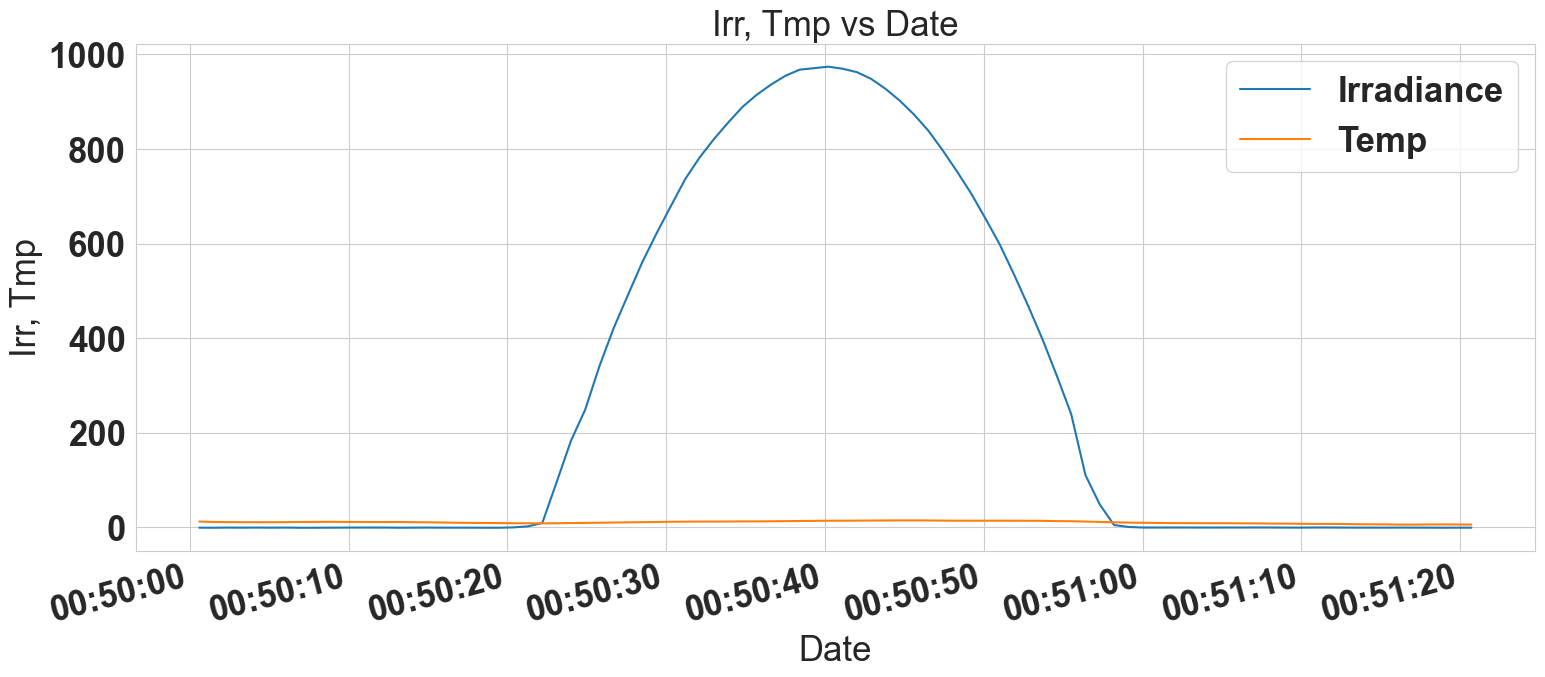

ylabel : Irr, Tmp


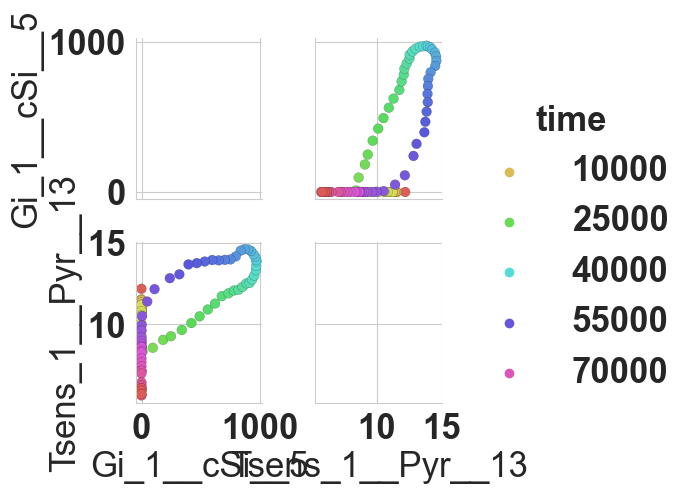

In [77]:
from gimodules.visualization import definedplots

xval = 'Gi_1__cSi__5'

definedplots.double_y_axis_plot(test_csv[3:], 'time', [xval, 'Tsens_1__Pyr__13'], yval_labels=['Irradiance', 'Temp'], ylabel='Irr, Tmp')

definedplots.pair_plot(test_csv[3:], [xval, 'Tsens_1__Pyr__13'], 'time', ylabel='Irr, Tmp')

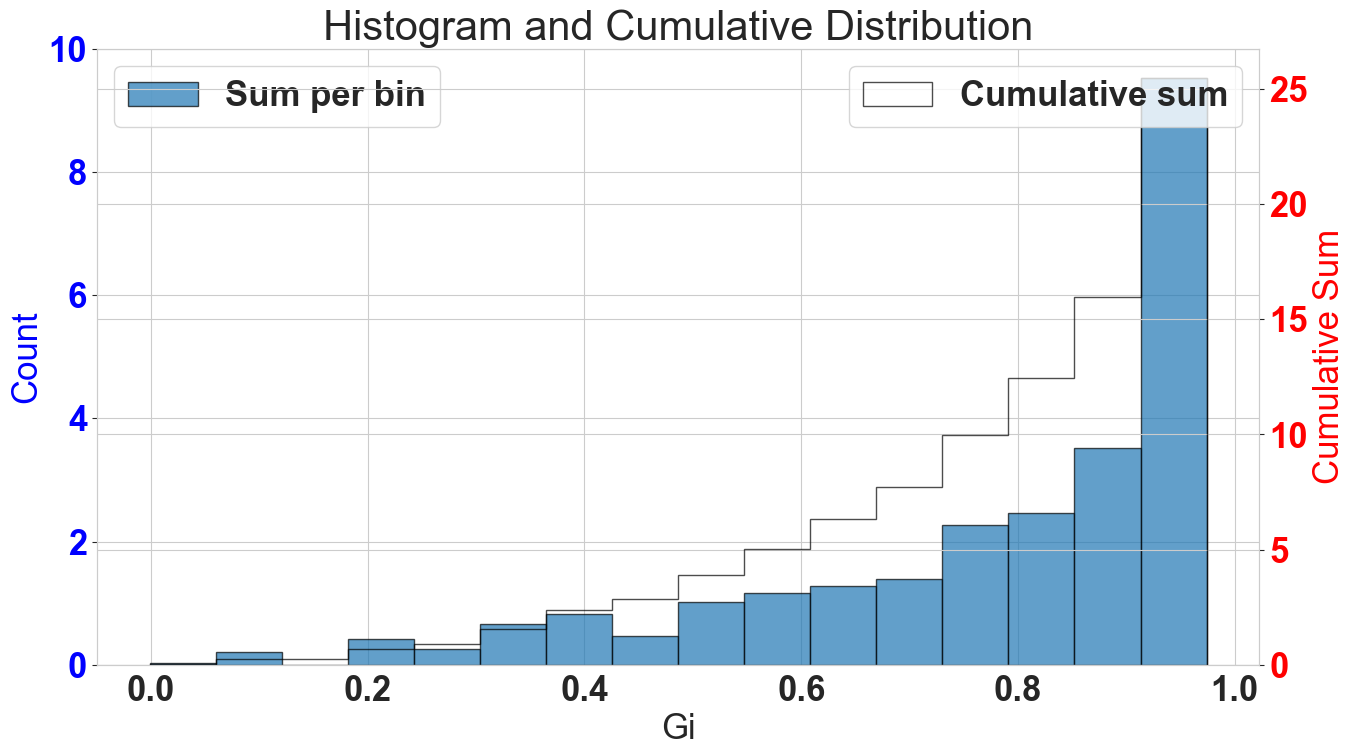

In [79]:
import pandas as pd

definedplots.hist_with_cumulative(test_csv[3:], xval, divider=1000, x_label='Gi')

/var/folders/ls/_2rnkbts7_9d833mngrvp1rh0000gn/T/ipykernel_96956/32073979.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ls/_2rnkbts7_9d833mngrvp1rh0000gn/T/ipykernel_96956/32073979.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ls/_2rnkbts7_9d833mngrvp1rh0000gn/T/ipykernel_96956/32073979.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

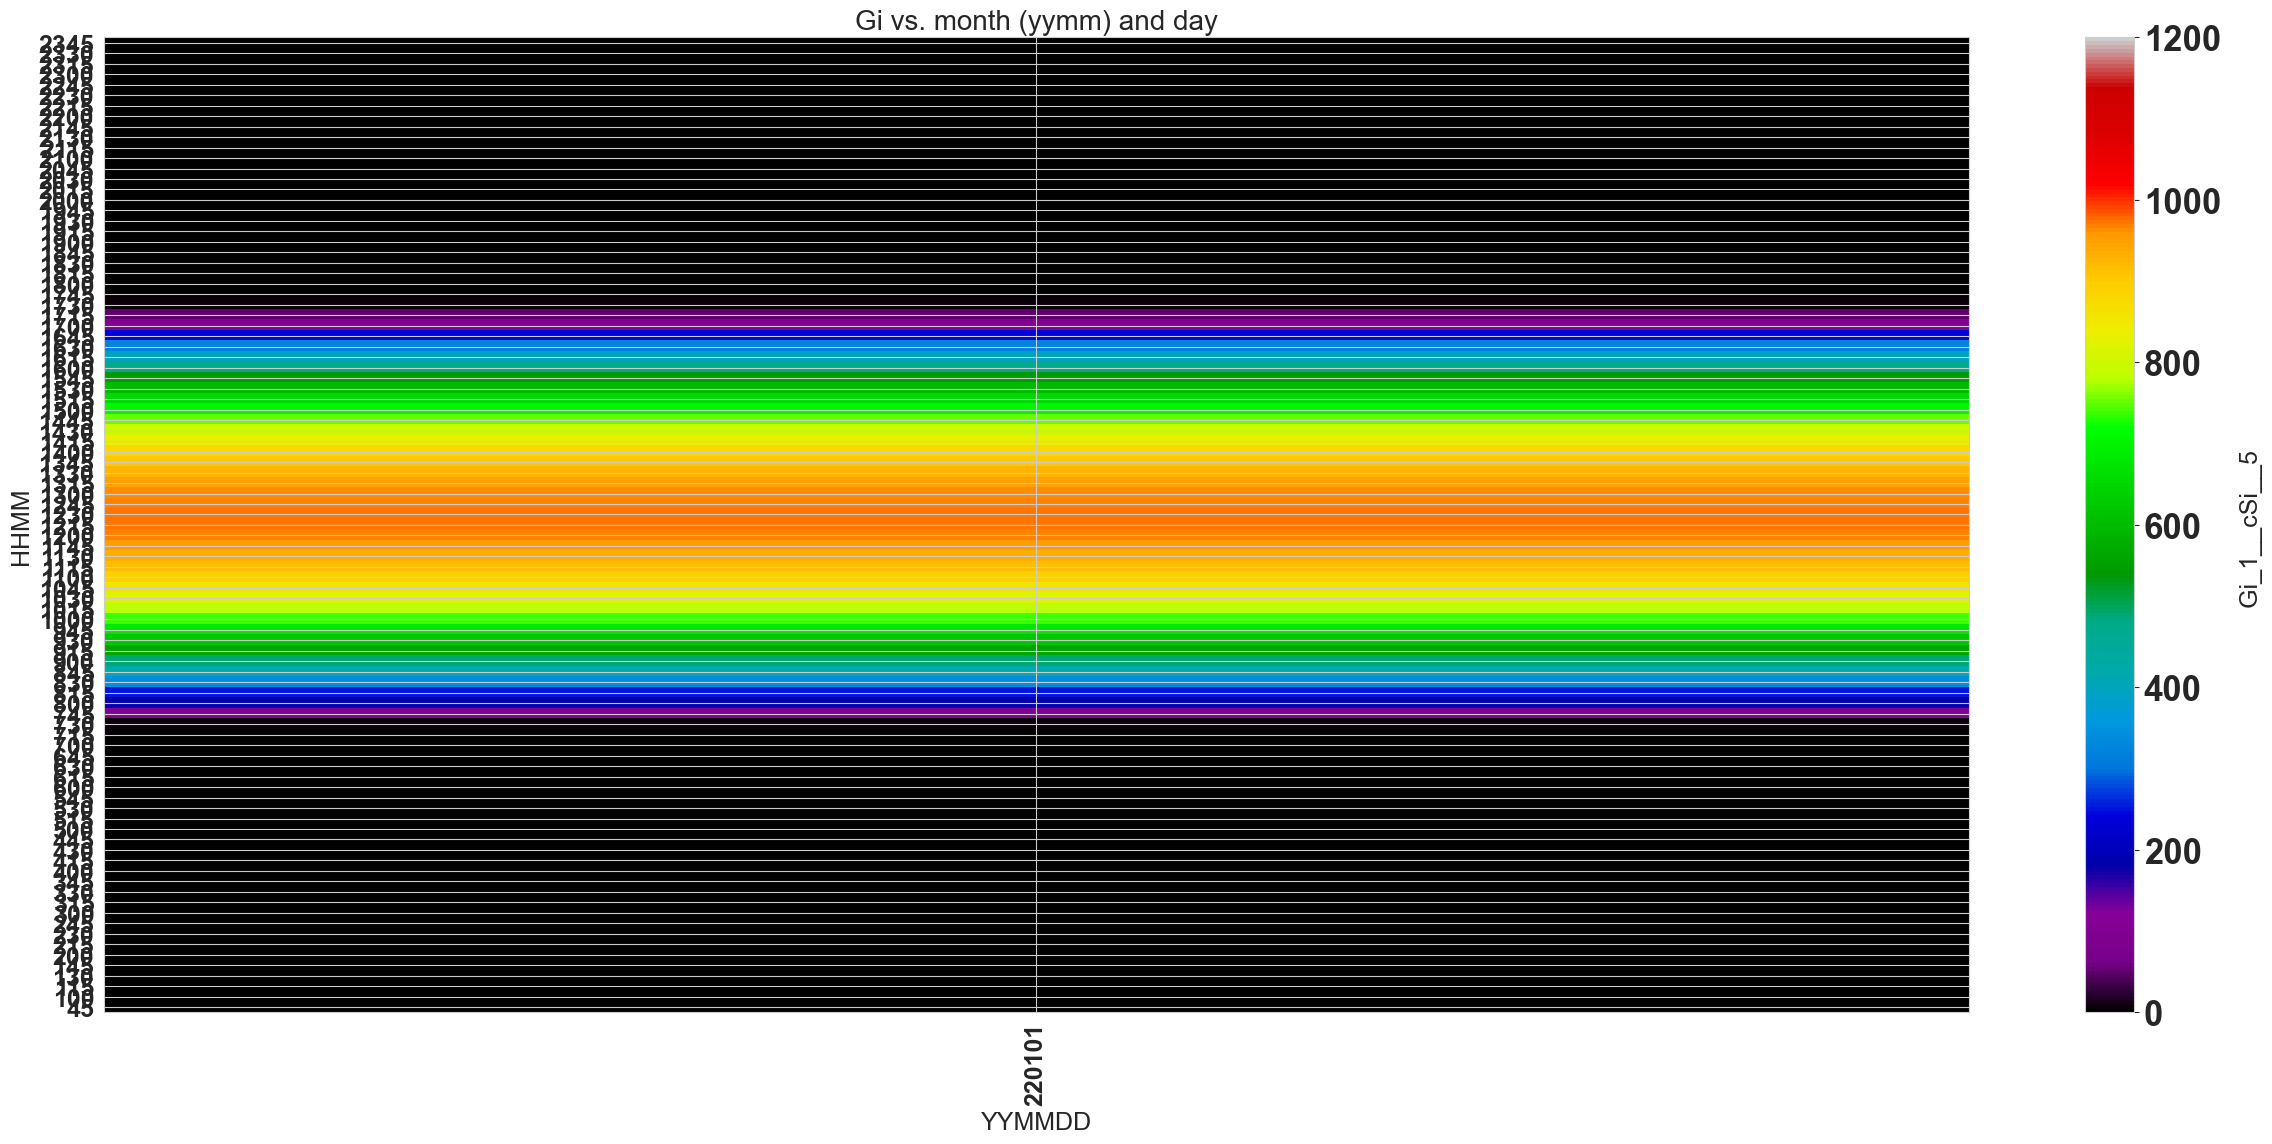

In [75]:
from datetime import timedelta

dd, hhmm = [], []

for indx, ts in enumerate(test_csv['time']):
    ts_adjusted = datetime.utcfromtimestamp(ts) - timedelta(hours=0)  # Apply timezone adjustment (UTC-7)
    dd.append(int(ts_adjusted.strftime('%Y%m%d')[2:]))
    hhmm.append(int(ts_adjusted.strftime('%H%M')))

# Add as new columns
test_csv['HHMM'] = hhmm
test_csv['YYMMDD'] = dd

# Change to numeric types
test_csv["YYMMDD"] = pd.to_numeric(test_csv["YYMMDD"], downcast="signed")


# Use Date columns in str format to create a heatmap
definedplots.define_heat_map(
    zval=xval,
    df=test_csv,
    start_yymmdd='220101',
    end_yymmdd='220102',
    yval='HHMM',
    xval='YYMMDD',
    vmin=0,
    vmax=1200,
    unit='',
    agg="max",
    colours='nipy_spectral',
    title=f'Gi vs. month (yymm) and day',
    save=False
)